In [2]:
%load_ext tikzmagic

---
slug: "/blog/initializationregularizationdropout"
date: "2021-04-08"
title: "Initialization, Regularization, and Dropout"
category: "2 Deep Learning"
order: 3
---

### Introduction

In my earlier post, titled *Classification and Regression with Neural Networks*, I explained the intuitions behind neural networks, and how to write a neural network from scratch in python using pytorch.
In this post, I will be discussing several common methods to generally improve neural network performance, including weight initialization, regularization, and dropout.

### Initialization

Initialization simply refers to the approach taken to set the initial values of weights in a neural network.
As networks get larger, the method chosen to initialize the weights can have a significant effect on the overall effectiveness of the network.

#### Random

Random initialization just means setting the weights of a hidden layer to small random values before beginning training. 
A common setting is to simply use random weight values in the range $[-0.1, 0.1]$.

In [ ]:
def RandomInitializer(inputdim: int, units: int) -> torch.Tensor:
    """ Returns randomly initialized weights in range [-1, 1]

    Args:
        inputdim: number of input units         
        units: number of units in layer

    Returns:
        initialized weight tensor            
    """

    return ((torch.rand((inputdim, units)) * 2) - 1) / 10

#### Glorot/Xavier

This method of initialization was designed to prevent possible saturation of parameters during training when using sigmoid and tanh activation functions.
Saturation occurs when hidden units become prematurely trapped at a particular value, causing learning to slow or not occur at all.

$$
\begin{aligned}
    W_{ij} &\sim U\left[ -\sqrt{\frac{1}{n}}, \sqrt{\frac{1}{n}} \right]\\
    U\left[-a, a\right] &= \text{ uniform distribution in the interval } (-a, a)\\
    n &= \text{ the number of units in the previous layer}\\
\end{aligned}
$$

In [ ]:
def GlorotInitializer(inputdim: int, units: int) -> torch.Tensor:
    """ Returns weights initialized using Glorot initialization 

    Args:
        inputdim: number of input units         
        units: number of units in layer

    Returns:
        initialized weight tensor            
    """

    tail = torch.sqrt(torch.Tensor([1/inputdim]))
    weights = (torch.rand((inputdim, units)) * tail * 2) - tail

    return weights

#### He

This method of initialization was also designed to prevent the possible saturation of parameters during training, but with a focus on the ReLU activation function.

$$
\begin{aligned}
    W_{ij} &\sim U\left[ -\sqrt{\frac{2}{n}}, \sqrt{\frac{2}{n}}\right]\\
    U\left[-a, a\right] &= \text{ uniform distribution in the interval } (-a, a)\\
    n &= \text{ the number of units in the previous layer}\\
\end{aligned}
$$

In [ ]:
def HeInitializer(inputdim: int, units: int) -> torch.Tensor:
    """ Returns weights initialized using He initialization 

    Args:
        inputdim: number of input units         
        units: number of units in layer

    Returns:
        initialized weight tensor            
    """

    tail = torch.sqrt(torch.Tensor([2/inputdim]))
    weights = (torch.rand((inputdim, units)) * tail * 2) - tail

    return weights

### Regularization

Regularization is a technique used to reduce model variance.
Regularization is not unique to neural networks and has been used with many different models prior to the widespread use of neural networks.
In general, the regularization term is a penalty applied to model parameters that favors simpler models to overly complex ones.

During training, the penalty $\Omega(w)$ is added to the loss function, and incorporated into the weight update during gradient descent.
The cost function $C(y, \hat{y}, w)$ below, shows how the penalty would be incorporated into model training.
The $\lambda$ constant multiplied to the penalty term becomes a new hyperparameter for the model.

$$
\begin{aligned}
    C(y, \hat{y}, w) &= L(y, \hat{y}) + \lambda \Omega(w)\\
    w &= w - \alpha \frac{\partial C}{\partial w} \\
    &= w - \alpha \left[ \frac{\partial L}{\partial w} + \lambda\frac{\partial \Omega(w)}{\partial w} \right]\\
\end{aligned}
$$

#### L1 Regularization

L1 regularization, also known as lasso regression, shrinks parameter values by adding the sum of the absolute value of weights to the loss function.

$$
\begin{aligned}
    \Omega(w) &= \sum^{N}_{i=1} |w_i| & \text{L1 Regularization}\\
    \frac{\partial \Omega(w)}{\partial w_i} &= 
    \frac{\partial}{\partial w_i}\sum^{N}_{j=1} |w_j| & \text{Derivative}\\
    &= \frac{\partial}{\partial w_i} |w_i| &\\
    &= \frac{w_i}{|w_i|} &\\
    &= \begin{cases}
        1 & w_i > 0\\
        -1 & w_i < 0\\
    \end{cases}&\\
    w_i &= \begin{cases}
        w_i - \alpha \left[ \frac{\partial L}{\partial w_i} + \lambda \right] & w_i > 0\\
        w_i - \alpha \left[ \frac{\partial L}{\partial w_i} - \lambda \right] & w_i < 0\\
    \end{cases}& \text{Weight update}\\
\end{aligned}
$$

In [ ]:
def L1Regularizer(w: torch.Tensor) -> torch.Tensor:
    """

    Args:

    Returns:
    """

    penalty = torch.sum(torch.abs(torch.clone(w)))
    grad = torch.clone(w)
    grad[grad >= 0] = 1
    grad[grad < 0] = -1

    return penalty, grad

#### L2 Regularization

L2 regularization, also known as ridge regression, shrinks parameter values by adding the sum of the squares of weights to the loss function.

$$
\begin{aligned}
    \Omega(w) &= \sum^N_{i=1} w_i^2 &\text{L2 Regularization}\\
    \frac{\partial \Omega(w)}{\partial w_i} &=
    \frac{\partial}{\partial w_i}\sum^N_{j=1} w_j^2 &\text{Derivative}\\
    &= \frac{\partial}{\partial w_i} w_i^2&\\
    &= 2w_i&\\
    w_i &= w_i - \alpha\left[\frac{\partial L}{\partial w_i} + 2\lambda w_i  \right] &\text{Weight update}\\
\end{aligned}
$$

In [ ]:
def L2Regularizer(w: torch.Tensor) -> torch.Tensor:
    """

    Args:

    Returns:
    """

    penalty = torch.sum(torch.square(torch.clone(w)))
    grad = 2 * torch.clone(w)

    return penalty, grad

### Dropout

Dropout is a simple regularization approach designed specifically for neural networks.
The dropout technique involves ignoring some of the hidden units in a layer during the training of a neural network.
When only a random proportion of network units are used during training, this approach is similar to the bagging ensemble method, as it is comparable to using multiple different network architectures simultaneously during training.

The graph below displays how dropout looks in a neural network.
The first graph shows a fully connected neural network without any units dropped out.
The second graph displays the same neural network but with one hidden unit dropped out in the first hidden layer, and two hidden units dropped out in the second hidden layer.

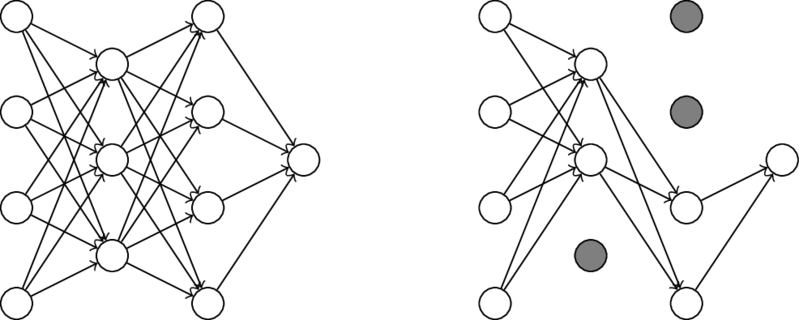

In [62]:
%%tikz -s=800,320 -sc=1
\node[draw, circle] (x1) at (0, 3) {};
\node[draw, circle] (x2) at (0, 2) {};
\node[draw, circle] (x3) at (0, 1) {};
\node[draw, circle] (x4) at (0, 0) {};
\node[draw, circle] (h11) at (1, 2.5) {};
\node[draw, circle] (h12) at (1, 1.5) {};
\node[draw, circle] (h13) at (1, 0.5) {};
\node[draw, circle] (h21) at (2, 3) {};
\node[draw, circle] (h22) at (2, 2) {};
\node[draw, circle] (h23) at (2, 1) {};
\node[draw, circle] (h24) at (2, 0) {};
\node[draw, circle] (o) at (3, 1.5) {};
\draw[->](x1) -- (h11); \draw[->](x1) -- (h12); \draw[->](x1) -- (h13);
\draw[->](x2) -- (h11); \draw[->](x2) -- (h12); \draw[->](x2) -- (h13);
\draw[->](x3) -- (h11); \draw[->](x3) -- (h12); \draw[->](x3) -- (h13);
\draw[->](x4) -- (h11); \draw[->](x4) -- (h12); \draw[->](x4) -- (h13);
\draw[->](h11) -- (h21); \draw[->](h11) -- (h22); \draw[->](h11) -- (h23); \draw[->](h11) -- (h24);
\draw[->](h12) -- (h21); \draw[->](h12) -- (h22); \draw[->](h12) -- (h23); \draw[->](h12) -- (h24);
\draw[->](h13) -- (h21); \draw[->](h13) -- (h22); \draw[->](h13) -- (h23); \draw[->](h13) -- (h24);
\draw[->](h21) -- (o); \draw[->](h22) -- (o); \draw[->](h23) -- (o); \draw[->](h24) -- (o);
\node[draw, circle] (x1b) at (5, 3) {};
\node[draw, circle] (x2b) at (5, 2) {};
\node[draw, circle] (x3b) at (5, 1) {};
\node[draw, circle] (x4b) at (5, 0) {};
\node[draw, circle] (h11b) at (6, 2.5) {};
\node[draw, circle] (h12b) at (6, 1.5) {};
\node[draw, circle, fill=gray] (h13b) at (6, 0.5) {};
\node[draw, circle, fill=gray] (h21b) at (7, 3) {};
\node[draw, circle, fill=gray] (h22b) at (7, 2) {};
\node[draw, circle] (h23b) at (7, 1) {};
\node[draw, circle] (h24b) at (7, 0) {};
\node[draw, circle] (ob) at (8, 1.5) {};
\draw[->](x1b) -- (h11b); \draw[->](x1b) -- (h12b);
\draw[->](x2b) -- (h11b); \draw[->](x2b) -- (h12b);
\draw[->](x3b) -- (h11b); \draw[->](x3b) -- (h12b);
\draw[->](x4b) -- (h11b); \draw[->](x4b) -- (h12b);
\draw[->] (h11b) -- (h23b); \draw[->] (h11b) -- (h24b);
\draw[->] (h12b) -- (h23b); \draw[->] (h12b) -- (h24b);
\draw[->] (h23b) -- (ob);
\draw[->] (h24b) -- (ob);

The code below shows an updated version of the `DefaltDenseLayer` class from my earlier post, titled *Classification and Regression with Neural Networks*.
The most significant changes occur in the `forward` function of the `DefaultDenseLayer` class.

In [ ]:
class DefaultDenseLayer(Layer): 
    """ Default dense layer class
    """


    def __init__(self, inputdim: int, units: int, activation: str, initializer: str=None, regularizer: str=None, dropout: float=None) -> None:
        """ Initialize default dense layer

        Args:
            inputdim: number of input units
            units: number of units in layer
            activation: activation function string => should be a key of ACTIVATIONS
            initializer: weight initialization scheme => should be a key of INITIALIZERS
            regularizer: regularization method => should be a key of REGULARIZERS
            dropout: probability that a hidden unit should be dropped out
        """

        self.w = INITIALIZERS[initializer](inputdim, units) if initializer else INITIALIZERS['random'](inputdim, units)
        self.regularizer = regularizer if regularizer else 'l'
        self.activation = activation
        self.dropout = dropout
        self.dz_dw = None
        self.dz_dx = None
        self.da_dz = None
        self.dr_dw = None


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Run forward pass through layer, saving local gradients

        Args:
            x: input data

        Returns:
            output of layer given input x
        """

        z, self.dz_dw, self.dz_dx = torch.einsum('ij,jk->ik', x, self.w), x, self.w
        a, self.da_dz = ACTIVATIONS[self.activation](z)

        if self.dropout:
            mask = torch.rand(a.shape)
            mask[mask <= self.dropout] = 0
            mask[mask > self.dropout] = 1
            a = (a * mask) / (1-self.dropout)
            self.da_dz = (self.da_dz * mask) / (1-self.dropout)

        r, self.dr_dw = REGULARIZERS[self.regularizer](self.w)

        return a, r


    def backward(self, dl: torch.Tensor, alpha: float, lambdaa: float=1.0) -> torch.Tensor:
        """ Run backward pass through layer, updating weights and returning
            cumulative gradient from last connected layer (output layer)
            backwards through to this layer

        Args:
            dl: cumulative gradient calculated from layers ahead of this layer
            alpha: learning rate
            lambdaa: regularization rate

        Returns:
            cumulative gradient calculated at this layer
        """

        dl_dz = self.da_dz * dl
        dl_dw = torch.einsum('ij,ik->jk', self.dz_dw, dl_dz) / dl.shape[0] 
        dl_dx = torch.einsum('ij,kj->ki', self.dz_dx, dl_dz)
        self.w -= alpha * (dl_dw + lambdaa * self.dr_dw)
        return dl_dx



### Resources

- Glorot, X., & Bengio, Y. (2010). *Understanding the difficulty of training deep feedforward neural networks*. In Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics (pp. 249–256). PMLR.
- He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*. In Proceedings of the 2015 IEEE International Conference on Computer Vision (ICCV) (pp. 1026–1034). IEEE Computer Society.
- Goodfellow, Ian, et al. *Deep Learning*. MIT Press, 2017. 
- Hastie, Trevor, et al. *The Elements of Statistical Learning: Data Mining, Inference, and Prediction*. Springer, 2009.